In [60]:
!pip install -q census us folium geopandas colorcet

In [63]:
%config InlineBackend.figure_formats = ["retina"]

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import folium
import colorcet as cc

from census import Census

In [3]:
census = Census("", year=2020)

# Week 2: Exploring the U.S. Census, part 2 (units, hierarchies, the central spine, ACS)

Last week, we examined some of the demographic data published by the U.S. Census Bureau. That demographic data is associated with geographic units: for instance, we examined population by race (and Hispanic/Latin origin) at the county level. To make sense of this data beyond basic summary statistics, it is extremely useful to superimpose it on a map. This week, we'll explore how to download and visualize Census geographies, and we'll create combine demographic data with these geographies to create [choropleth maps](https://en.wikipedia.org/wiki/Choropleth_map).

## Loading geographical data

Census geographies are published as _shapefiles_. The [ESRI shapefile format](https://en.wikipedia.org/wiki/Shapefile) is extremely popular among GIS (geographic information systems) practictioners, and any serious mapping tool (such as [ArcGIS](https://www.arcgis.com/index.html)) can read shapefiles. [GeoPandas](https://geopandas.org/en/stable/getting_started/introduction.html) is a Python package that extends Pandas to support reading shapefiles and plotting geographies; we'll use this package extensively in the coming weeks to build geospatial visualizations. Let's start by downloading a shapefile containing the outlines of all U.S. counties from the Census website.

In [47]:
county_gdf = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2024/COUNTY/tl_2024_us_county.zip").set_index("GEOID")

In [48]:
county_gdf.head(5)

STATEFP COUNTYFP  COUNTYNS         GEOIDFQ       NAME          NAMELSAD  \
GEOID                                                                           
31039      31      039  00835841  0500000US31039     Cuming     Cuming County   
53069      53      069  01513275  0500000US53069  Wahkiakum  Wahkiakum County   
35011      35      011  00933054  0500000US35011    De Baca    De Baca County   
31109      31      109  00835876  0500000US31109  Lancaster  Lancaster County   
31129      31      129  00835886  0500000US31129   Nuckolls   Nuckolls County   

      LSAD CLASSFP  MTFCC CSAFP CBSAFP METDIVFP FUNCSTAT       ALAND  \
GEOID                                                                  
31039   06      H1  G4020  None   None     None        A  1477563042   
53069   06      H1  G4020  None   None     None        A   680980773   
35011   06      H1  G4020  None   None     None        A  6016818941   
31109   06      H1  G4020   339  30700     None        A  2169269508   
31129   06      H1  G4020  None   None     None        A  1489645201   

         AWATER     INTPTLAT      INTPTLON  \
GEOID                                        
31039  10772508  +41.9158651  -096.7885168   
53069  61564428  +46.2946377  -123.4244583   
35011  29090018  +34.3592729  -104.3686961   
31109  22850511  +40.7835474  -096.6886584   
31129   1718484  +40.1764918  -098.0468422   

                                                geometry  
GEOID                                                     
31039  POLYGON ((-96.55525 41.82892, -96.55524 41.827...  
53069  POLYGON ((-123.72755 46.26449, -123.72755 46.2...  
35011  POLYGON ((-104.89337 34.08894, -104.89337 34.0...  
31109  POLYGON ((-96.68493 40.52330, -96.69219 40.523...  
31129  POLYGON ((-98.27370 40.11840, -98.27374 40.122...

GeoPandas includes a `.plot()` function (similar to the `.plot.pie()` and `.plot.bar()` Pandas functions we saw last week). With this function, we can quickly get a sense of what `county_gdf` contains.

/opt/anaconda3/envs/mggg/lib/python3.10/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


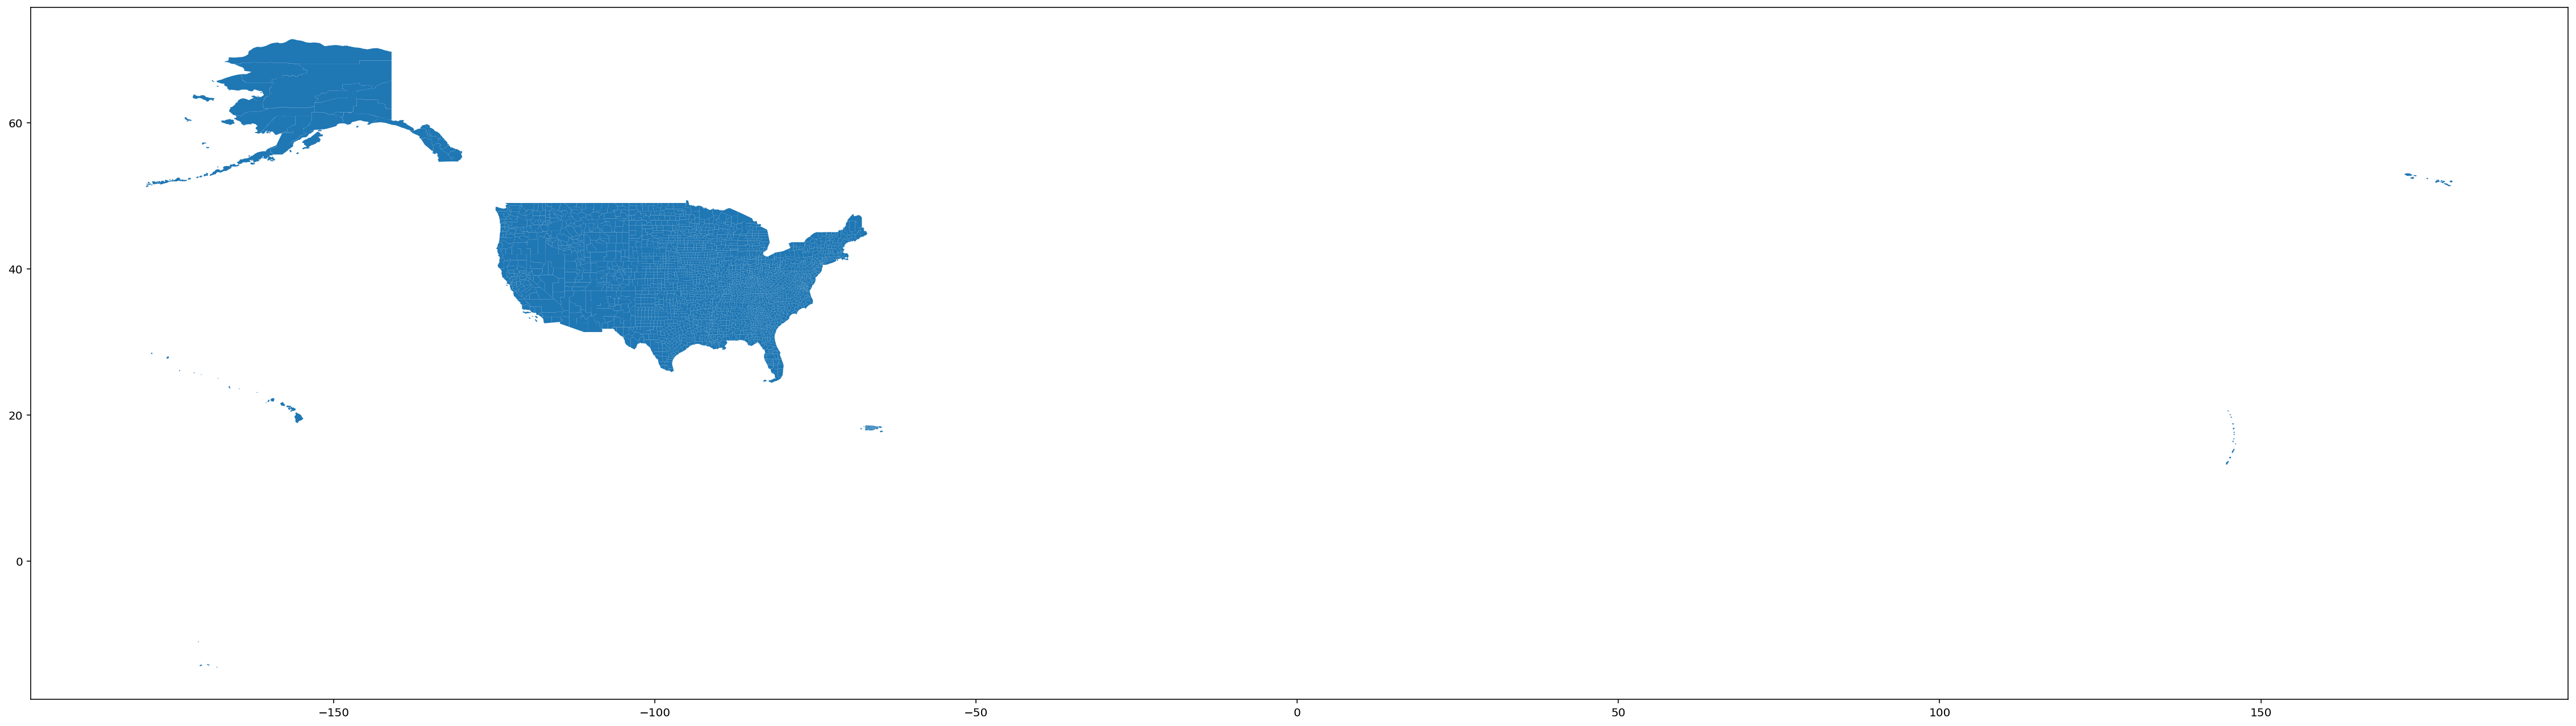

In [6]:
county_gdf.plot(figsize=(40, 80))
plt.show()

There's a problem with this initial visualization: it's mostly empty space! This is because the county shapefile covers _all_ territories of the U.S., including some Pacific territories (Guam, American Samoa, and the Northern Mariana Islands) that appear in the upper right of this plot. Let's narrow down the visualization to the continental U.S by filtering on FIPS code (conveniently, the outlying territories all have FIPS codes above 56).

In [56]:
# Filter out American Samoa, U.S. Virgin Islands, etc.
continental_gdf = county_gdf[
      (county_gdf.STATEFP <= "56")
    & (county_gdf.STATEFP != "02")  # exclude Alaska
    & (county_gdf.STATEFP != "15")  # exclude Hawaii
]

/opt/anaconda3/envs/mggg/lib/python3.10/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


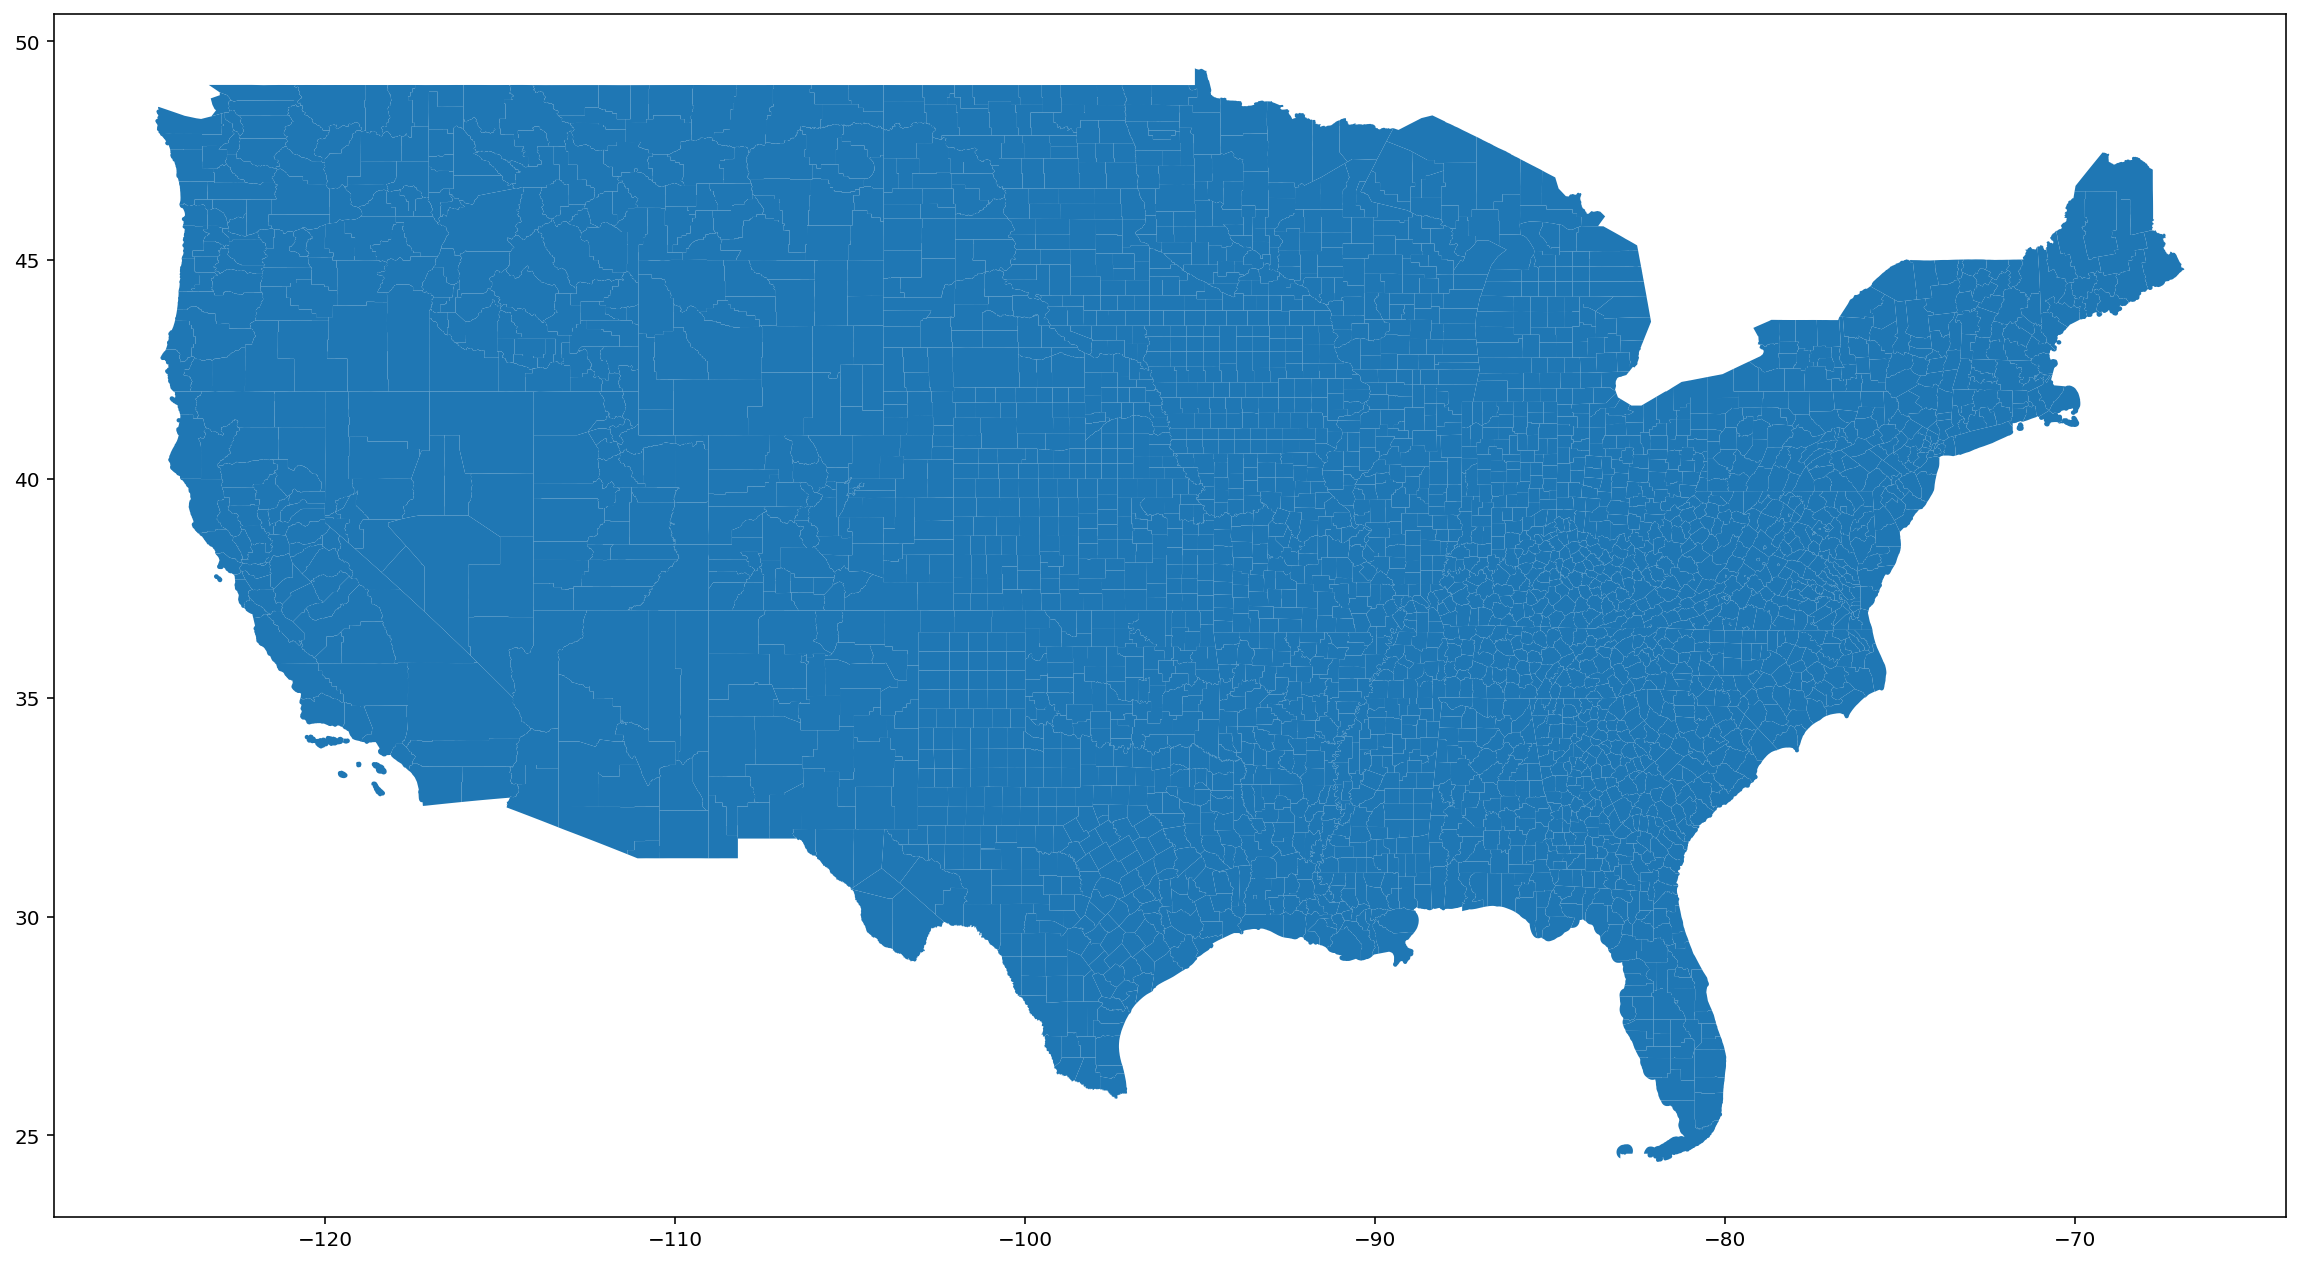

In [58]:
continental_gdf.plot(figsize=(20, 40))
plt.show()

That's better! Now, let's color the map by state (using the `STATEFP` column, which contains the state FIPS code for each county). Note that some of the state borders look a little odd (this effect is most pronounced in Michigan); this is because the Census geographies include some water areas.

/opt/anaconda3/envs/mggg/lib/python3.10/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


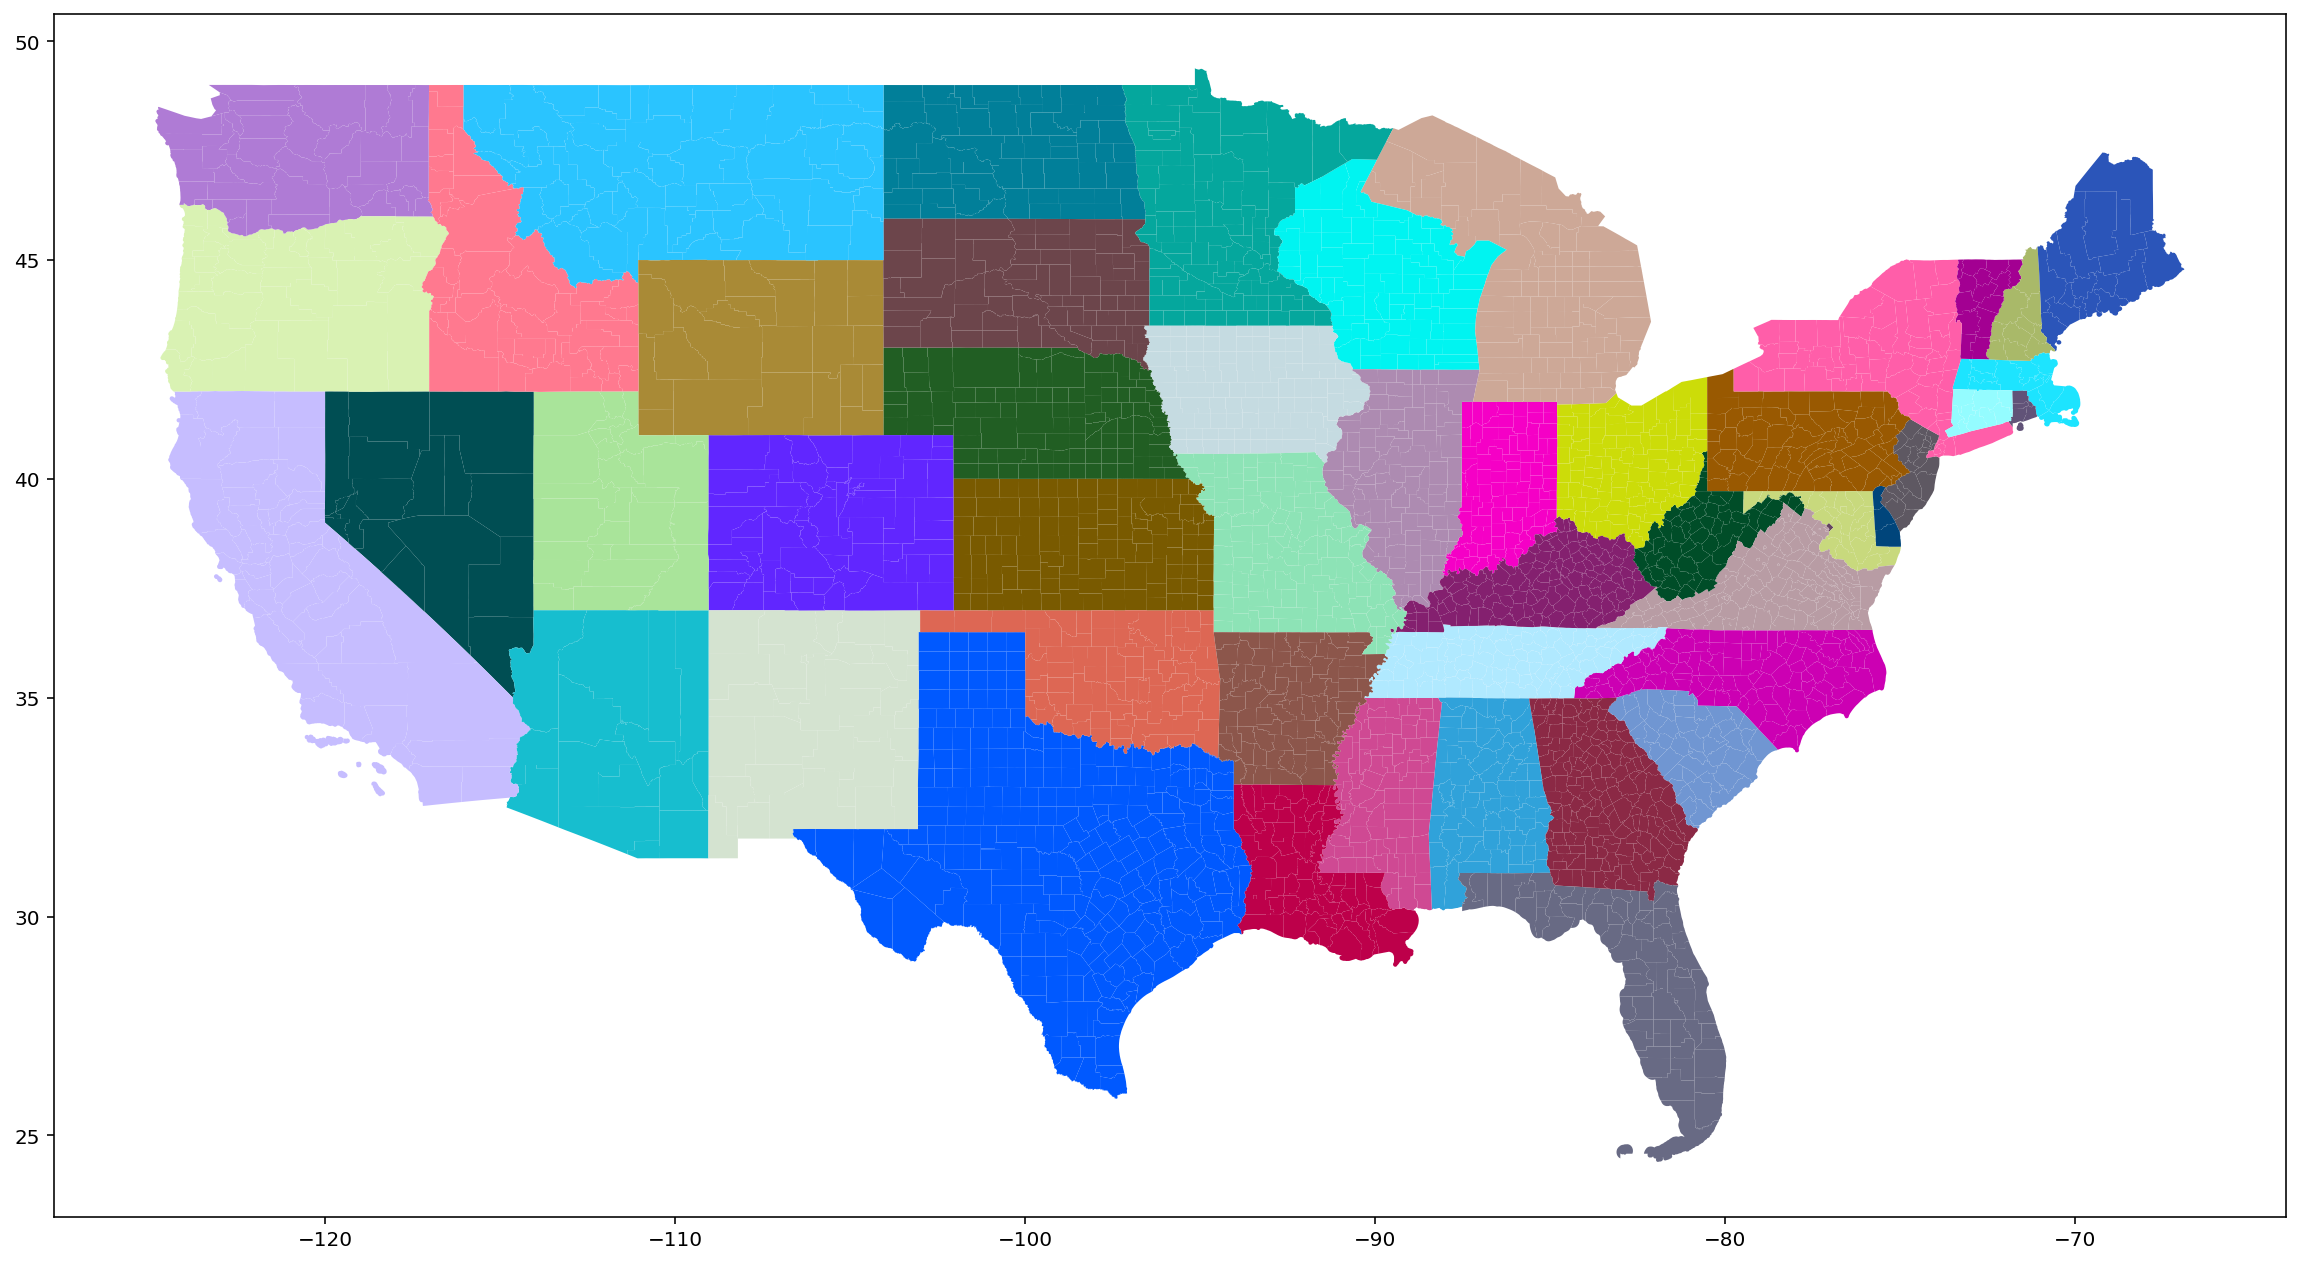

In [81]:
continental_gdf.plot(figsize=(20, 40), column="STATEFP", cmap=cc.cm.glasbey_hv)
plt.show()

## Choosing a map projection

You may have noticed... [@Moon, how much do we want to get into this?]

ref: 
* [Choosing the right map projection](https://source.opennews.org/articles/choosing-right-map-projection/)
* [geopandas.GeoDataFrame.plot()](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html)

In [10]:
continental_gdf.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [11]:
continental_gdf = continental_gdf.to_crs("EPSG:2163")

In [12]:
continental_gdf.crs

<Derived Projected CRS: EPSG:2163>
Name: US National Atlas Equal Area
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - onshore and offshore.
- bounds: (167.65, 15.56, -65.69, 74.71)
Coordinate Operation:
- name: US National Atlas Equal Area
- method: Lambert Azimuthal Equal Area (Spherical)
Datum: Not specified (based on Clarke 1866 Authalic Sphere)
- Ellipsoid: Clarke 1866 Authalic Sphere
- Prime Meridian: Greenwich

/opt/anaconda3/envs/mggg/lib/python3.10/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


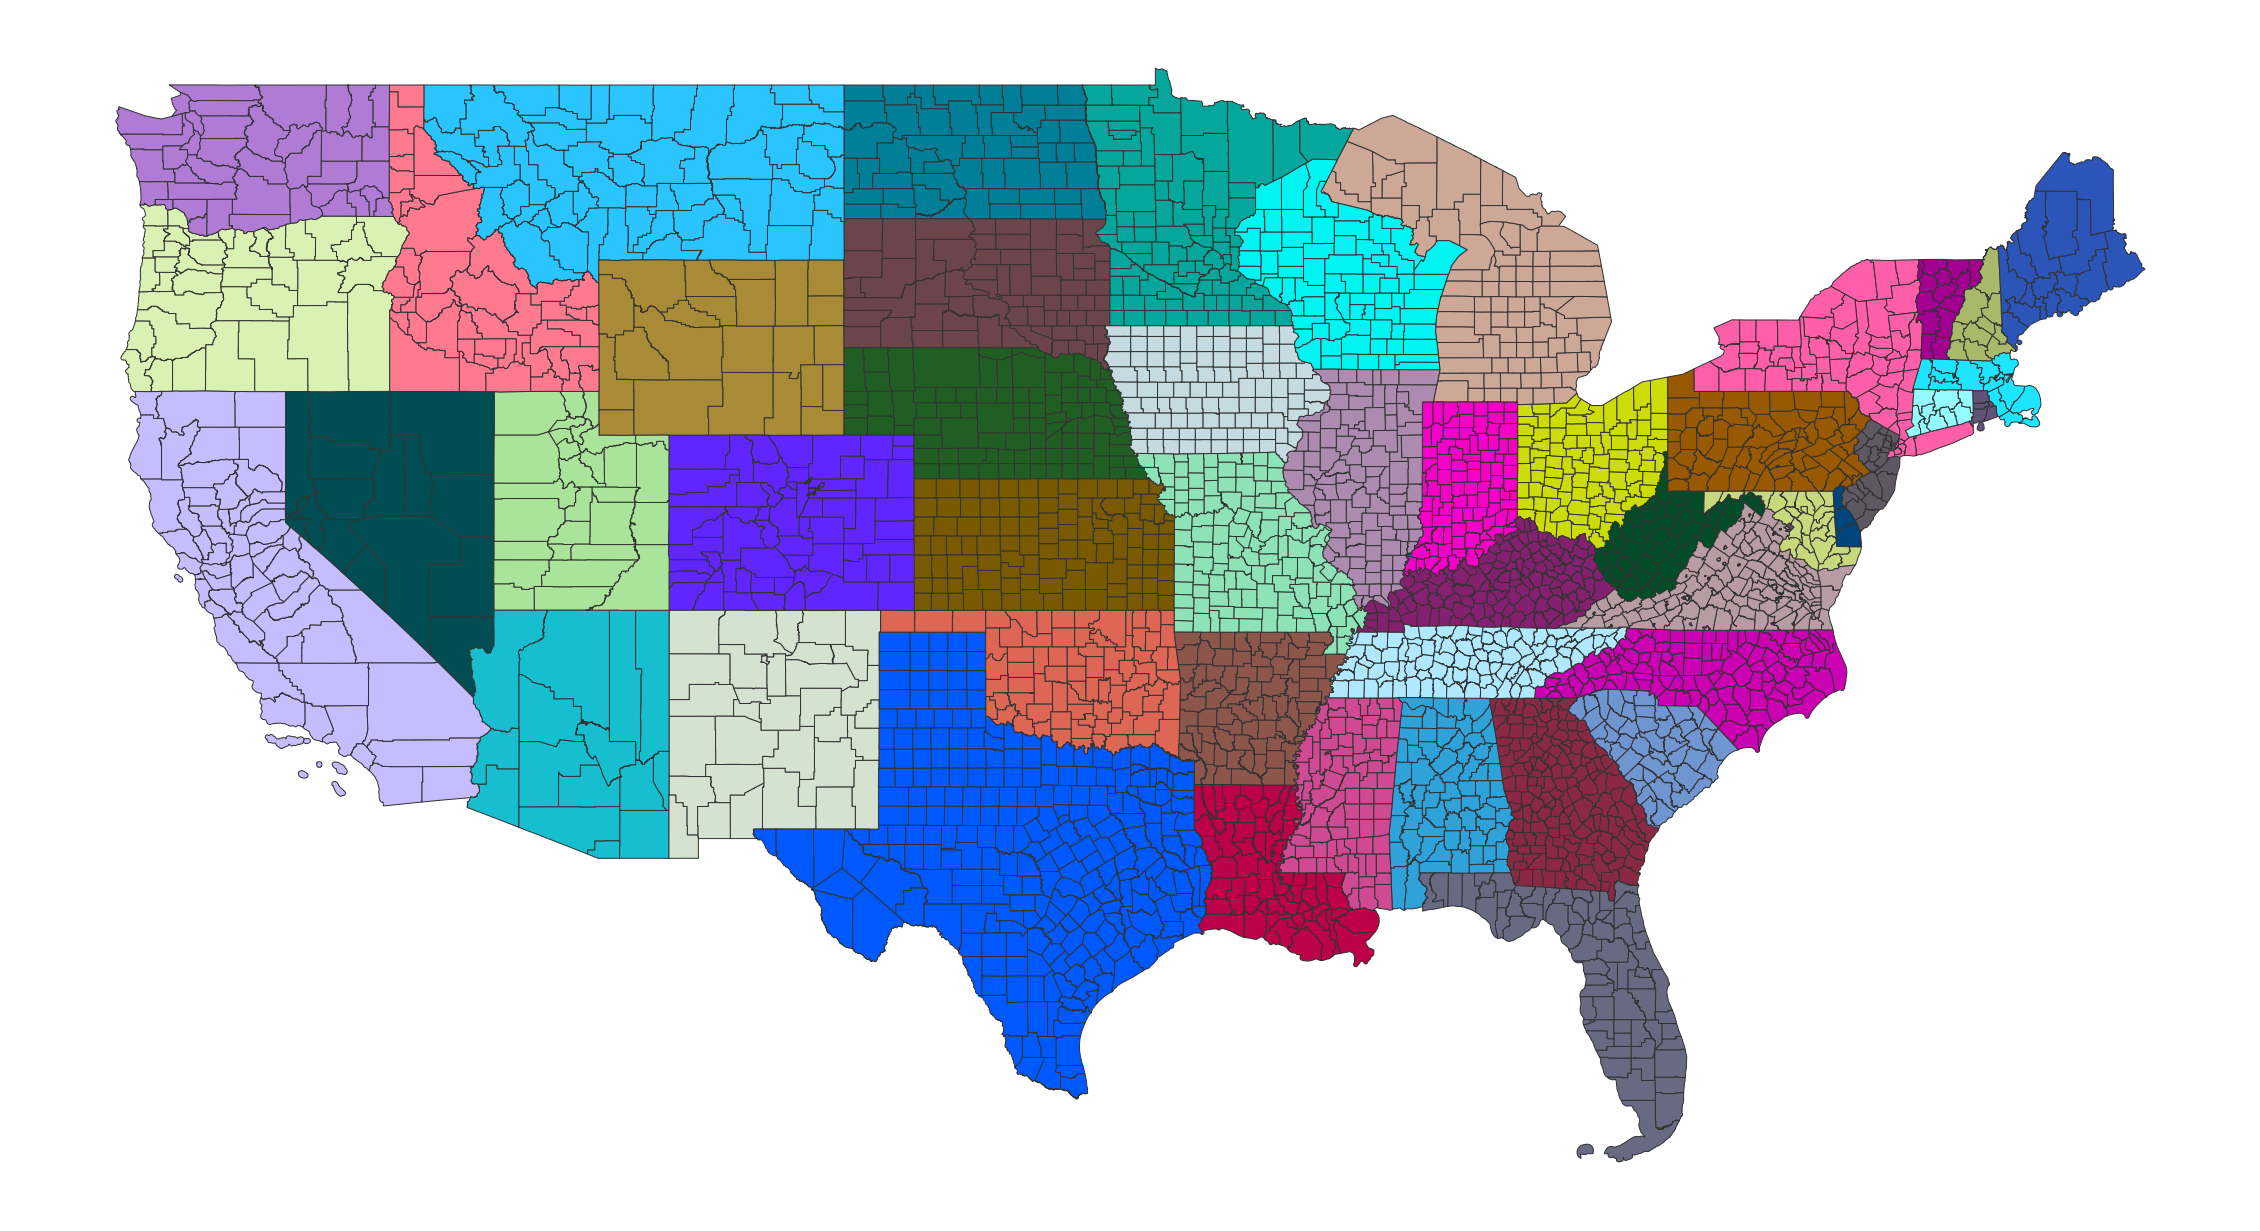

In [80]:
continental_gdf.plot(figsize=(20, 40), column="STATEFP", cmap=cc.cm.glasbey_hv, edgecolor="0.2", linewidth=0.5)
plt.axis("off")
plt.show()

## The Census unit hierarchy

The core Census geographic units are organized into hierarchy (sometimes referred to as _the central spine_): states contain counties, which contain _tracts_, which contain _block groups_, which contain _blocks_. States and counties are (mostly) static political units with boundaries generally not determined by the Census; tracts, block groups, and blocks are statistical units defined by the Census. These statistical units are subject to change for each decennial Census. Blocks are the most granular unit in this hierarchy, and [many Census blocks are unpopulated](https://mapsbynik.com/maps/census0pop/).

![U.S. Census central spine (source: University of Missouri)](https://mcdc.missouri.edu/geography/sumlevs/censusgeochart.png)

_(image credit: University of Missouri)_

The Census also publishes data for political and statistical areas that do not fall neatly in this spine. For instance, school districts nest in states, but they do not necessarily nest in counties; voting districts nest in counties, but not necessarily in tracts.

Let's examine how the state of New York is broken up into various Census units, starting with counties—the least granular unit (below the state level) on the central spine.

### Counties
The U.S. Census releases a county shapefile at the national level; to plot just the counties in New York, we need to filter by state FIPS code.

In [14]:
ny_county_gdf = continental_gdf[continental_gdf.STATEFP == "36"]

In [82]:
ny_county_gdf.head(5)

STATEFP COUNTYFP  COUNTYNS         GEOIDFQ      NAME         NAMELSAD  \
GEOID                                                                         
36101      36      101  00974148  0500000US36101   Steuben   Steuben County   
36091      36      091  00974143  0500000US36091  Saratoga  Saratoga County   
36003      36      003  00974100  0500000US36003  Allegany  Allegany County   
36075      36      075  00974136  0500000US36075    Oswego    Oswego County   
36111      36      111  00974153  0500000US36111    Ulster    Ulster County   

      LSAD CLASSFP  MTFCC CSAFP CBSAFP METDIVFP FUNCSTAT       ALAND  \
GEOID                                                                  
36101   06      H1  G4020   236  18500     None        A  3601403378   
36091   06      H1  G4020   104  10580     None        A  2097812305   
36003   06      H1  G4020  None   None     None        A  2666410173   
36075   06      H1  G4020   532  45060     None        A  2464685608   
36111   06      H1  G4020   408  28740     None        A  2911757764   

          AWATER     INTPTLAT      INTPTLON  \
GEOID                                         
36101   35034921  +42.2667252  -077.3855253   
36091   87488004  +43.1061353  -073.8553872   
36003   12989704  +42.2478532  -078.0261531   
36075  933435238  +43.4614431  -076.2092618   
36111   94596810  +41.9472124  -074.2654582   

                                                geometry  
GEOID                                                     
36101  POLYGON ((1863679.495 -69943.717, 1862846.152 ...  
36091  POLYGON ((2097657.278 111500.074, 2097654.483 ...  
36003  POLYGON ((1773035.415 -35352.294, 1773048.206 ...  
36075  POLYGON ((1892479.108 138751.855, 1892877.792 ...  
36111  POLYGON ((2095324.049 13879.747, 2095324.485 1...

/opt/anaconda3/envs/mggg/lib/python3.10/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


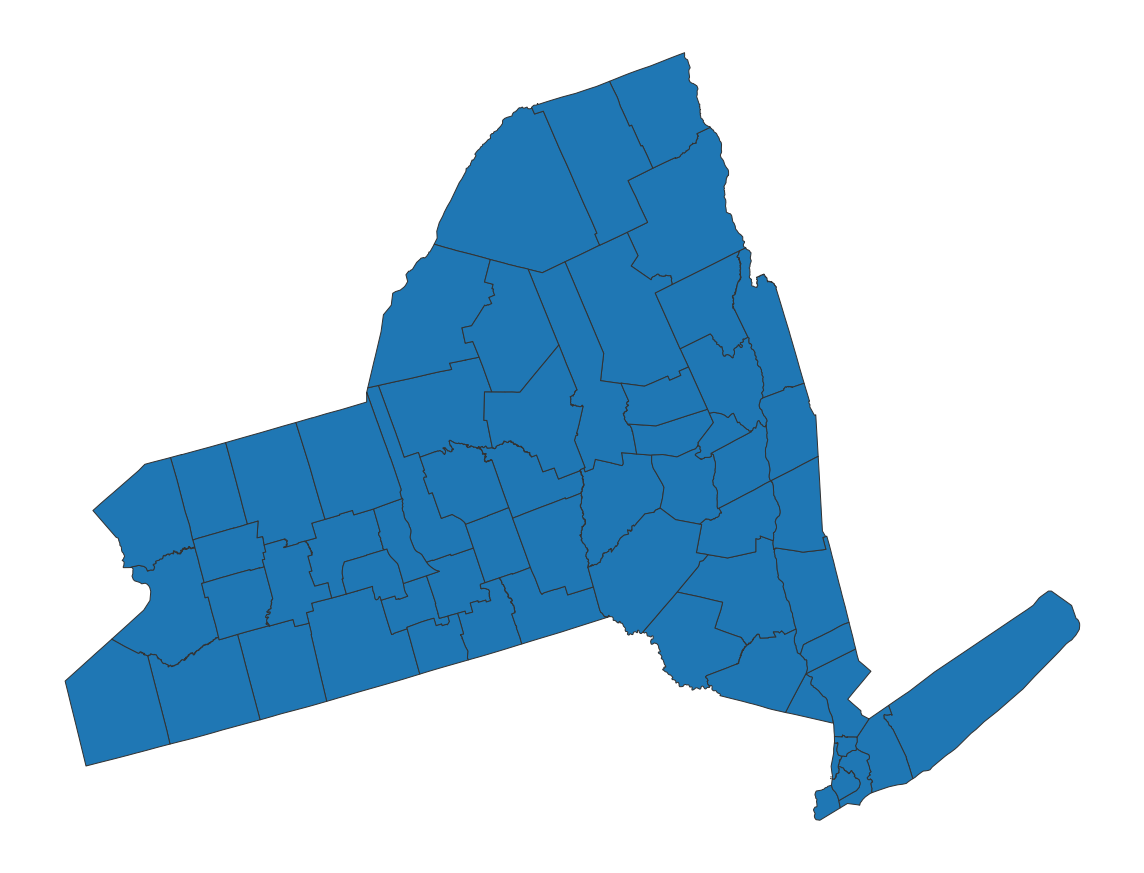

In [16]:
ny_county_gdf.plot(figsize=(10, 20), edgecolor="0.2", linewidth=0.5)
plt.axis("off")
plt.show()

### County subdivisions

For reporting purposes, the Census divides counties into _county subdivisions_. These subdivisions generally correspond to preexisting political divisions: towns, cities, incorporated places, and the like. (For more on how county subdivisions are defined, see [chapter 8 of the _Geographic Areas Reference Manual_](https://www2.census.gov/geo/pdfs/reference/GARM/Ch8GARM.pdf).)

In [17]:
ny_cousub_gdf = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2024/COUSUB/tl_2024_36_cousub.zip").set_index("GEOID").to_crs("EPSG:2163")

In [41]:
ny_cousub_gdf.head(5)

STATEFP COUNTYFP COUSUBFP  COUSUBNS              GEOIDFQ  \
GEOID                                                                 
3601755959      36      017    55959  00979335  0600000US3601755959   
3601757507      36      017    57507  00979360  0600000US3601757507   
3601758288      36      017    58288  00979370  0600000US3601758288   
3601759817      36      017    59817  00979398  0600000US3601759817   
3601766894      36      017    66894  00979490  0600000US3601766894   

                 NAME        NAMELSAD LSAD CLASSFP  MTFCC FUNCSTAT      ALAND  \
GEOID                                                                           
3601755959     Oxford     Oxford town   43      T1  G4040        A  155563470   
3601757507  Pharsalia  Pharsalia town   43      T1  G4040        A  100533127   
3601758288    Pitcher    Pitcher town   43      T1  G4040        A   73723906   
3601759817    Preston    Preston town   43      T1  G4040        A   89940325   
3601766894  Sherburne  Sherburne town   43      T1  G4040        A  112803620   

            AWATER     INTPTLAT      INTPTLON  \
GEOID                                           
3601755959  911062  +42.3970735  -075.5962276   
3601757507  774336  +42.5976196  -075.7338789   
3601758288   37391  +42.5875820  -075.8279559   
3601759817  830446  +42.5033261  -075.6103565   
3601766894   51669  +42.6939737  -075.4812144   

                                                     geometry  
GEOID                                                          
3601755959  POLYGON ((1961875.504 4567.571, 1961895.797 45...  
3601757507  POLYGON ((1944260.143 29128.119, 1944618.457 2...  
3601758288  POLYGON ((1937635.589 27005.517, 1937685.562 2...  
3601759817  POLYGON ((1956840.801 22763.914, 1956855.885 2...  
3601766894  POLYGON ((1959849.949 45897.012, 1959935.360 4...

/opt/anaconda3/envs/mggg/lib/python3.10/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


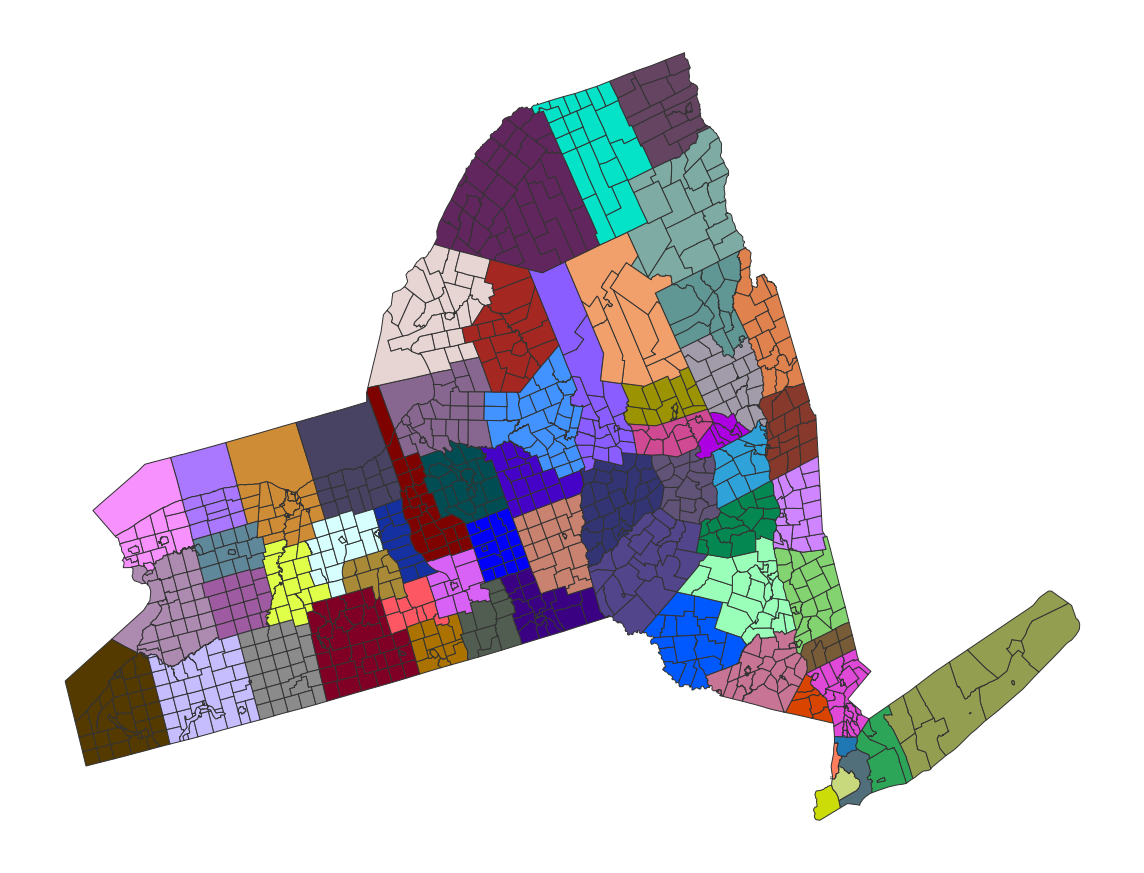

In [84]:
ny_cousub_gdf.plot(figsize=(10, 20), column="COUNTYFP", cmap=cc.cm.glasbey_hv, edgecolor="0.2", linewidth=0.5)
plt.axis("off")
plt.show()

### Tracts
Census tracts are immediately below counties on the central spine. While counties in New York (and most states) vary wildly in population, the populations of Census tracts are much more constrained: [according to the U.S. Census](https://www.census.gov/programs-surveys/geography/about/glossary.html#par_textimage_13), "Census tracts generally have a population size between 1,200 and 8,000 people, with an optimum size of 4,000 people". Because of this uniformity, the density of Census tracts roughly corresponds to population density. In the map below, observe the high density of small tracts in major population centers like New York City and the low density of large tracts in the sparsely populated upstate regions.

In [20]:
ny_tract_gdf = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2024/TRACT/tl_2024_36_tract.zip").set_index("GEOID").to_crs("EPSG:2163")

In [42]:
ny_tract_gdf.head(5)

STATEFP COUNTYFP TRACTCE               GEOIDFQ    NAME  \
GEOID                                                                
36093033102      36      093  033102  1400000US36093033102  331.02   
36093020102      36      093  020102  1400000US36093020102  201.02   
36093032504      36      093  032504  1400000US36093032504  325.04   
36081003400      36      081  003400  1400000US36081003400      34   
36081003900      36      081  003900  1400000US36081003900      39   

                        NAMELSAD  MTFCC FUNCSTAT      ALAND   AWATER  \
GEOID                                                                  
36093033102  Census Tract 331.02  G5020        S  183329990  3232878   
36093020102  Census Tract 201.02  G5020        S     854905        0   
36093032504  Census Tract 325.04  G5020        S   65999125  1264687   
36081003400      Census Tract 34  G5020        S     213987        0   
36081003900      Census Tract 39  G5020        S     146970        0   

                INTPTLAT      INTPTLON  \
GEOID                                    
36093033102  +42.7780248  -074.1727005   
36093020102  +42.8295375  -073.9161408   
36093032504  +42.9010539  -074.0288936   
36081003400  +40.6847731  -073.8581871   
36081003900  +40.7627994  -073.9409316   

                                                      geometry  
GEOID                                                           
36093033102  POLYGON ((2055264.586 78050.871, 2055271.488 7...  
36093020102  POLYGON ((2082062.894 95284.550, 2082080.039 9...  
36093032504  POLYGON ((2064585.726 105492.982, 2064979.986 ...  
36081003400  POLYGON ((2159378.165 -132226.337, 2159433.986...  
36081003900  POLYGON ((2150689.280 -125953.316, 2150710.253...

/opt/anaconda3/envs/mggg/lib/python3.10/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


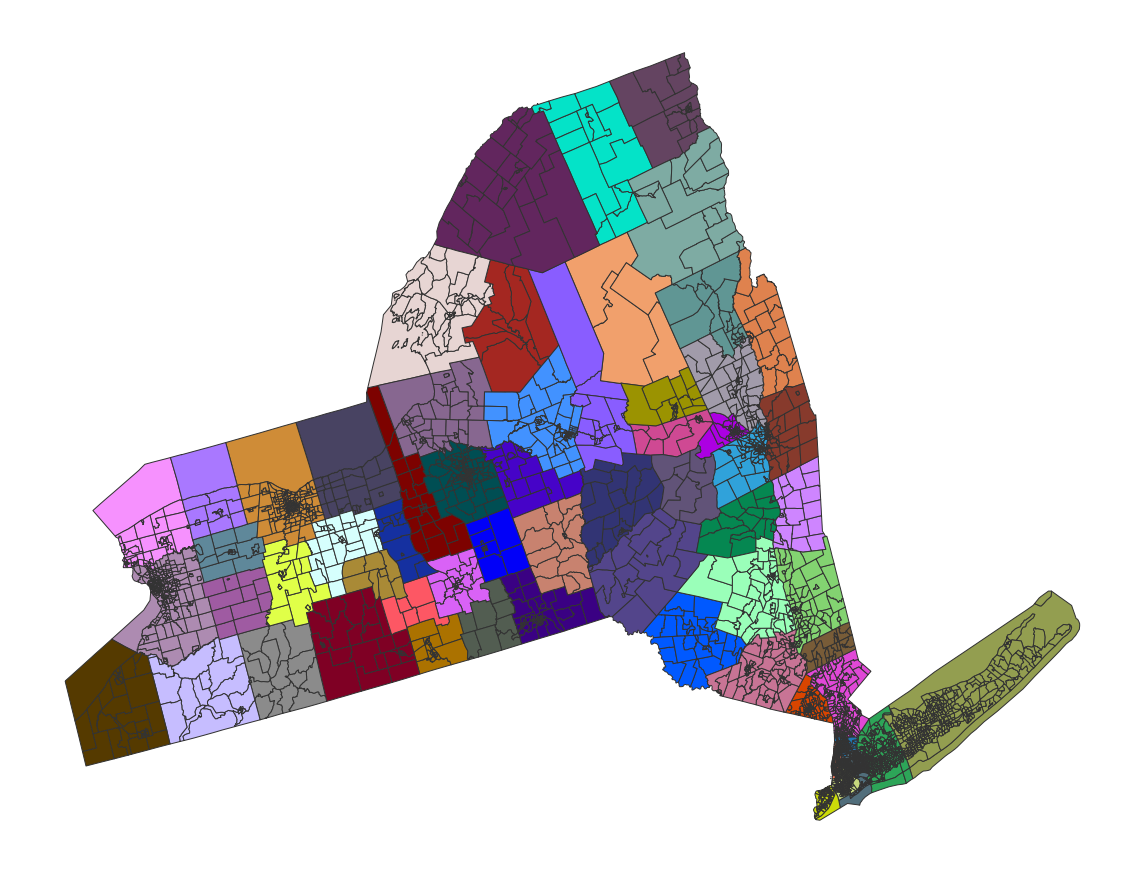

In [86]:
ny_tract_gdf.plot(figsize=(10, 20), column="COUNTYFP", cmap=cc.cm.glasbey_hv, edgecolor="0.2", linewidth=0.5)
plt.axis("off")
plt.show()

We can filter by FIPS code to zoom in on a particular county. Here is Kings County, which is coterminous with the borough of Brooklyn.

In [87]:
brooklyn_tract_gdf = ny_tract_gdf[ny_tract_gdf.COUNTYFP == "047"]

In [88]:
brooklyn_tract_gdf.head(5)

STATEFP COUNTYFP TRACTCE               GEOIDFQ  NAME  \
GEOID                                                              
36047021100      36      047  021100  1400000US36047021100   211   
36047048500      36      047  048500  1400000US36047048500   485   
36047062000      36      047  062000  1400000US36047062000   620   
36047080800      36      047  080800  1400000US36047080800   808   
36047123700      36      047  123700  1400000US36047123700  1237   

                      NAMELSAD  MTFCC FUNCSTAT   ALAND  AWATER     INTPTLAT  \
GEOID                                                                         
36047021100   Census Tract 211  G5020        S  271830       0  +40.6970856   
36047048500   Census Tract 485  G5020        S  581535       0  +40.7078399   
36047062000   Census Tract 620  G5020        S  319578   34799  +40.5788518   
36047080800   Census Tract 808  G5020        S  321836       0  +40.6573033   
36047123700  Census Tract 1237  G5020        S  321360       0  +40.6967384   

                 INTPTLON                                           geometry  
GEOID                                                                         
36047021100  -073.9719259  POLYGON ((2149833.910 -133632.831, 2150031.799...  
36047048500  -073.9363455  POLYGON ((2152528.113 -131108.635, 2152686.219...  
36047062000  -073.9460579  POLYGON ((2155966.786 -145680.844, 2156040.377...  
36047080800  -073.9394864  POLYGON ((2153831.736 -137151.752, 2154005.580...  
36047123700  -073.9567404  POLYGON ((2151373.744 -133109.624, 2151436.766...

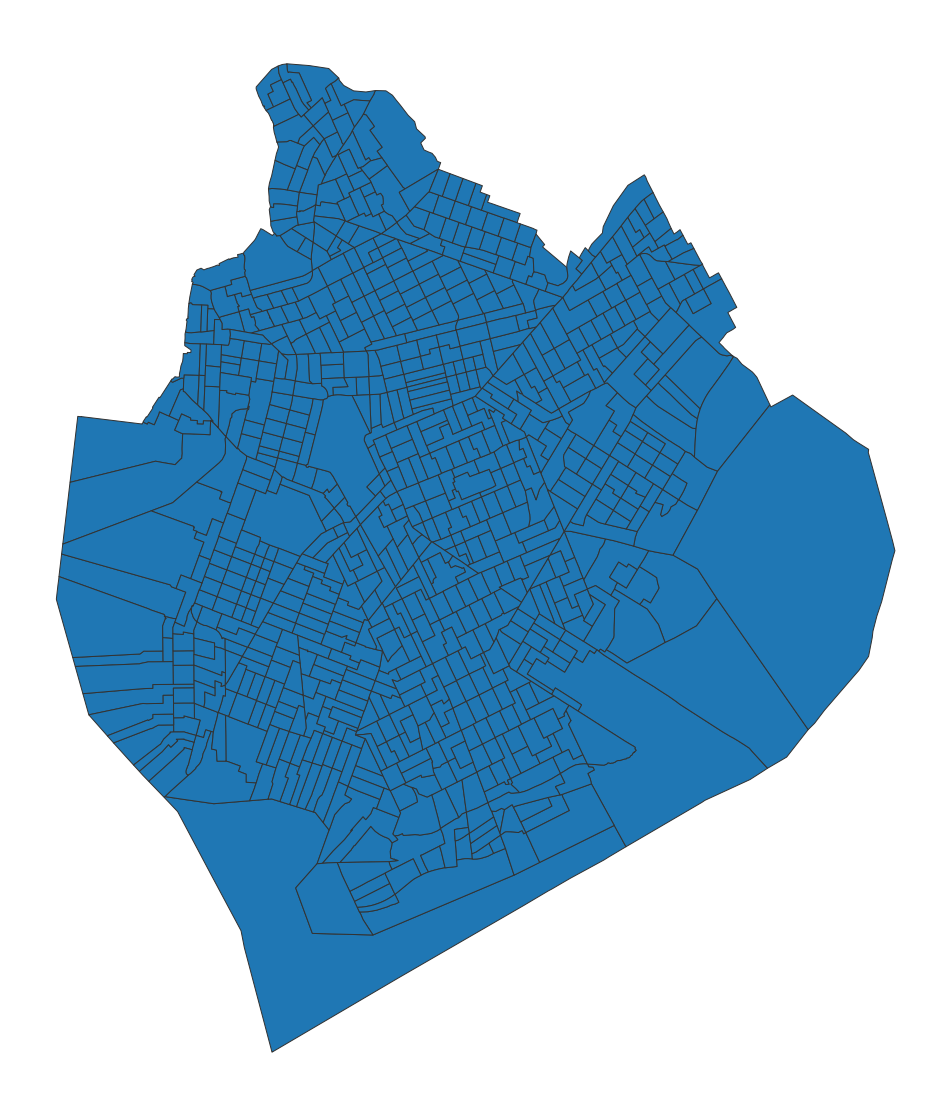

In [25]:
brooklyn_tract_gdf.plot(figsize=(10, 10), edgecolor="0.2", linewidth=0.5)
plt.axis("off")
plt.show()

We can see that Census tracts loosely correspond to city blocks, or at least generally follow the city's grid.

<img width="512" alt="Brooklyn neighborhoods map" src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f2/Brooklyn_neighborhoods_map.png/512px-Brooklyn_neighborhoods_map.png?20090719024832">

_(image credit: <a href="https://commons.wikimedia.org/wiki/File:Brooklyn_neighborhoods_map.png">Peter Fitzgerald</a>, <a href="https://creativecommons.org/licenses/by/3.0">CC BY 3.0</a>, via Wikimedia Commons)_

## Combining geographies with ACS data

In addition to publishing decennial data, the U.S. Census Bureau publishes [American Community Survey](https://www.census.gov/programs-surveys/acs) (ACS) data every year. The ACS is sent to a random sample of U.S. addresses; ACS data includes population estimates by race and ethnicity (which is useful for understanding demographic shifts between decennial Censuses), but it is also an invaluable source for understanding economic and social trends. As a simple example, let's take a look at a subset of the means of transportation data available in the ACS.

In [31]:
brooklyn_subway_usage_raw = census.acs5.get(
    (
        # Means of Transportation to Work – Total
        "B08301_001E",  
        # Means of Transportation to Work – Total – Public transportation (excluding taxicab) – Subway or elevated rail
        "B08301_012E",  
    ),
    geo={
        "for": "tract:*",
        "in": f"state:36 county:047",
    },
    year=2022,
)

In [32]:
brooklyn_subway_usage_df = pd.DataFrame(brooklyn_subway_usage_raw).rename(
    columns={
        "B08301_001E": "commuter_count",
        "B08301_012E": "subway_commuter_count",
    }
)

In [33]:
brooklyn_subway_usage_df

commuter_count  subway_commuter_count state county   tract
0            2731.0                 1108.0    36    047  000100
1             618.0                  243.0    36    047  000200
2            2219.0                  994.0    36    047  000301
3            2271.0                  734.0    36    047  000501
4            1596.0                  844.0    36    047  000502
..              ...                    ...   ...    ...     ...
800          2630.0                  939.0    36    047  122000
801          1716.0                  107.0    36    047  123700
802          1212.0                  509.0    36    047  150200
803          2126.0                  539.0    36    047  152200
804             0.0                    0.0    36    047  990100

[805 rows x 5 columns]

In [34]:
brooklyn_subway_usage_df["GEOID"] = (
    brooklyn_subway_usage_df["state"]
    + brooklyn_subway_usage_df["county"]
    + brooklyn_subway_usage_df["tract"]
)
brooklyn_subway_usage_df = brooklyn_subway_usage_df.set_index("GEOID")
brooklyn_subway_usage_df["subway_pct"] = 100 * brooklyn_subway_usage_df["subway_commuter_count"] / brooklyn_subway_usage_df["commuter_count"] 

In [35]:
brooklyn_subway_usage_df.sort_values(by=["subway_pct"])

commuter_count  subway_commuter_count state county   tract  \
GEOID                                                                     
36047070202            14.0                    0.0    36    047  070202   
36047005302            41.0                    0.0    36    047  005302   
36047053700           942.0                    0.0    36    047  053700   
36047047200           699.0                   26.0    36    047  047200   
36047070601          1176.0                   55.0    36    047  070601   
...                     ...                    ...   ...    ...     ...   
36047103402             0.0                    0.0    36    047  103402   
36047107002             0.0                    0.0    36    047  107002   
36047107003             0.0                    0.0    36    047  107003   
36047118000             0.0                    0.0    36    047  118000   
36047990100             0.0                    0.0    36    047  990100   

             subway_pct  
GEOID                    
36047070202    0.000000  
36047005302    0.000000  
36047053700    0.000000  
36047047200    3.719599  
36047070601    4.676871  
...                 ...  
36047103402         NaN  
36047107002         NaN  
36047107003         NaN  
36047118000         NaN  
36047990100         NaN  

[805 rows x 6 columns]

In [36]:
brooklyn_subway_usage_df = brooklyn_subway_usage_df[brooklyn_subway_usage_df.commuter_count > 0]

In [37]:
brooklyn_subway_usage_gdf = brooklyn_tract_gdf.join(brooklyn_subway_usage_df)

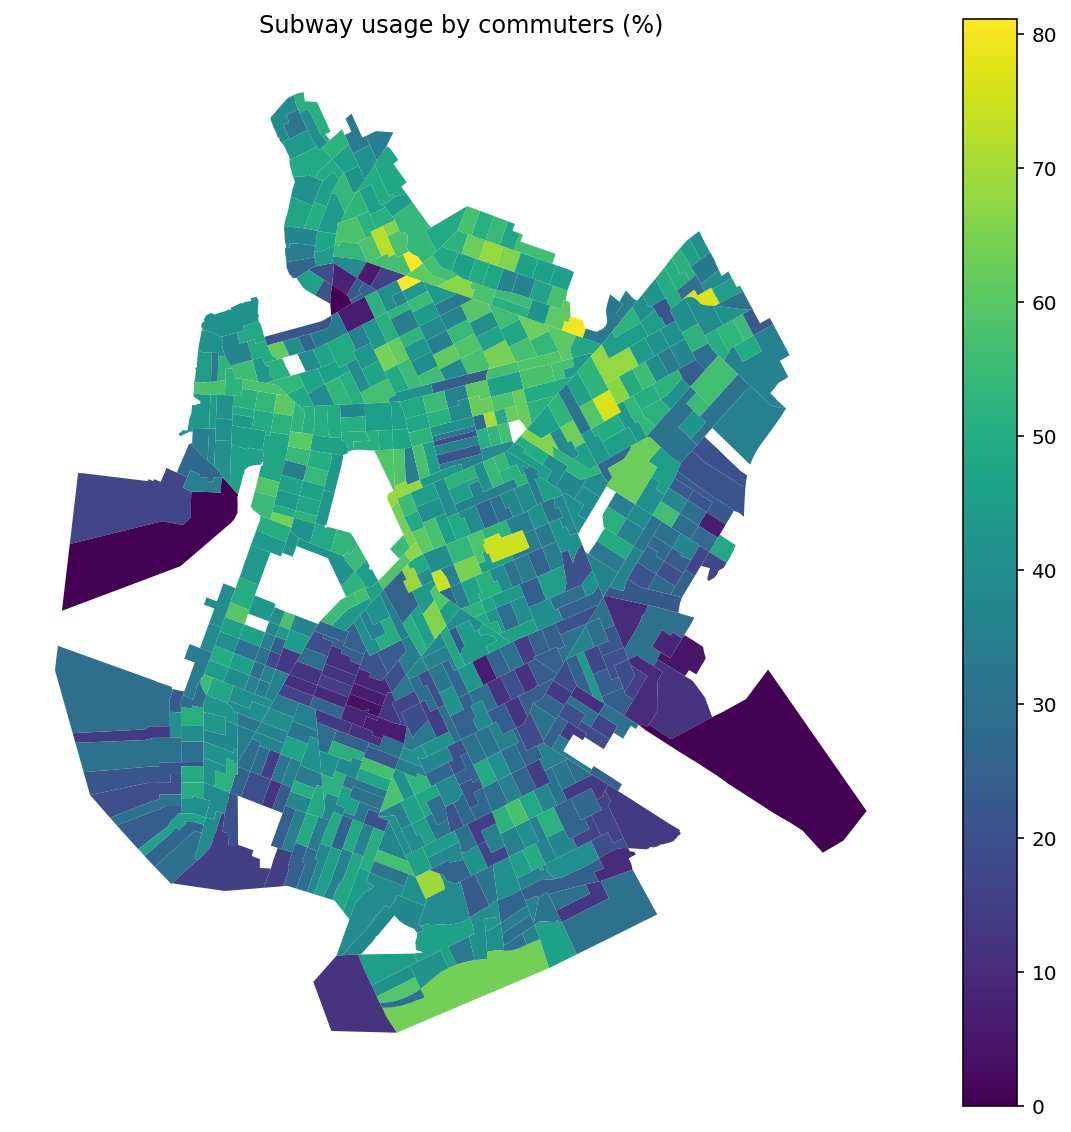

In [38]:
ax = brooklyn_subway_usage_gdf.plot(figsize=(10, 10), column="subway_pct", legend=True)
ax.axis("off")
ax.set_title("Subway usage by commuters (%)")
plt.show()

In [39]:
subway_map = folium.Map([40.65, -73.95], zoom_start=12)
folium.GeoJson(brooklyn_subway_usage_gdf).add_to(subway_map)
subway_map

In [40]:
subway_map = folium.Map([40.65, -73.95], zoom_start=12)
folium.Choropleth(
    geo_data=brooklyn_subway_usage_gdf,
    name="choropleth",
    data=state_data,
    columns=["State", "Unemployment"],
    key_on="feature.id",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Unemployment Rate (%)",
    
    
    
    brooklyn_subway_usage_gdf
).add_to(subway_map)
subway_map

SyntaxError: positional argument follows keyword argument (3215144473.py, line 16)